In [171]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import math

In [172]:
# import warnings

# warnings.filterwarnings("ignore", category=FutureWarning, message=".*DataFrame.swapaxes.*")

# import pandas as pd
# import numpy as np
# from tqdm import tqdm
# import os
# path='/kaggle/input/nasa-battery-dataset'
# metadata = pd.read_csv(os.path.join(path, "cleaned_dataset", "metadata.csv"))
# metadata['battery_id'] = metadata['battery_id'].astype(str)


# excluded_batteries = ['B0049', 'B0050', 'B0051', 'B0052']

# discharge_metadata = metadata[
#     (metadata['type'] == 'discharge') &
#     (~metadata['battery_id'].isin(excluded_batteries))
# ].copy()

# discharge_metadata['cycle_number'] = discharge_metadata.groupby('battery_id').cumcount() + 1

# processed_dfs = []

# # Process each discharge cycle
# for _, row in tqdm(discharge_metadata.iterrows(), total=len(discharge_metadata)):
#     file_path = os.path.join(path, "cleaned_dataset", "data", row['filename'])
#     df = pd.read_csv(file_path).copy()

#     # Truncate data at the first point where voltage < 2.7V
#     cutoff_idx = df[df['Voltage_measured'] < 2.7].index.min()
#     truncated_df = df if pd.isna(cutoff_idx) else df.iloc[:cutoff_idx].copy()

#     # Compute capacity using coulomb counting (sum of current over time)
#     truncated_df['Time_diff_hr'] = truncated_df['Time'].diff().fillna(0) / 3600
#     truncated_df['Delta_Q'] = truncated_df['Current_measured'] * truncated_df['Time_diff_hr']
#     capacity = abs(truncated_df['Delta_Q'].sum())

#     # Only use cycles with capacity above threshold (filter out bad data)
#     if capacity > 1.4:
#         # Add battery and cycle info columns
#         truncated_df['battery_id'] = row['battery_id']
#         truncated_df['cycle_number'] = row['cycle_number']
#         # Calculate SoC using coulomb counting
#         truncated_df['Cumulative_Q'] = truncated_df['Delta_Q'].cumsum()
#         truncated_df['SoC'] = 100 * (1 + truncated_df['Cumulative_Q'] / capacity)
#         # Calculate SoH as percentage of nominal capacity (2.0 Ah)
#         soh_value = (capacity / 2.0) * 100
#         truncated_df['SoH'] = soh_value

#         # Downsample each cycle to 20 bins by averaging (for uniform length)
#         num_bins = 20
#         bins = np.array_split(truncated_df, num_bins)
#         agg_rows = []
#         for b in bins:
#             if b.empty:
#                 continue
#             avg_voltage = b['Voltage_measured'].mean()
#             avg_current = b['Current_measured'].mean()
#             avg_temp = b['Temperature_measured'].mean()
#             avg_soc = b['SoC'].mean()
#             agg_rows.append({
#                 'Voltage_measured': avg_voltage,
#                 'Current_measured': avg_current,
#                 'Temperature_measured': avg_temp,
#                 'SoC': avg_soc,
#                 'cycle_number': b['cycle_number'].iloc[0],
#                 'battery_id': b['battery_id'].iloc[0],
#                 'SoH': b['SoH'].iloc[0]
#             })
#         cycle_df = pd.DataFrame(agg_rows)
#         # Only accept cycles that yield exactly 20 bins
#         if len(cycle_df) != num_bins:
#             continue
#         processed_dfs.append(cycle_df)
# # Concatenate all cycles and save as new CSV
# if processed_dfs:
#     full_dataset = pd.concat(processed_dfs)
#     print(f"Final dataset shape: {full_dataset.shape}")
#     full_dataset.to_csv("battery_health_dataset.csv", index=False)


In [173]:

df_csv=pd.read_csv('/kaggle/input/final-dataset-csv/battery_health_dataset.csv')
df_csv = df_csv.drop(columns=['battery_id'], errors='ignore')
df = df_csv.groupby("cycle_number", as_index=False).mean()
temp=df['Temperature_measured' ]
current=df["Current_measured"]
voltage=df["Voltage_measured"]
soc=df["SoC"]
cycle_number=df["cycle_number"]
soh_true=df["SoH"]

In [174]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(5,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,1)
        )
    def forward(self,voltage,soc,current,temp,cycles):
        x=torch.cat([voltage, soc, current, temp, cycles], dim=1)
        return self.net(x)

In [175]:
def physics_loss(model, cycle_number, voltage, soc, current, temp,
                 lambda_c=0.3, lambda_e=0.3):
    """
    Physics-informed loss for SOH estimation
    Includes ONLY:
    - Coulomb counting degradation
    - Energy throughput degradation
    """

    # Cycle number acts as time
    cycle_number = cycle_number.clone().detach().requires_grad_(True)

    # Forward pass
    soh = model(voltage, soc, current, temp, cycle_number)

    # dSOH / dCycle
    dsoh_dcycle = torch.autograd.grad(
        soh.sum(), cycle_number,
        create_graph=True
    )[0]

    k_c = 1e-4
    coulomb_res = dsoh_dcycle + k_c * torch.abs(current)
    loss_coulomb = torch.mean(coulomb_res ** 2)

   
    k_e = 1e-5
    energy_res = dsoh_dcycle + k_e * voltage * torch.abs(current)
    loss_energy = torch.mean(energy_res ** 2)

    
    loss_phys = lambda_c * loss_coulomb + lambda_e * loss_energy

    return loss_phys


In [176]:
from torchmetrics.regression import (
    R2Score,
    MeanAbsoluteError,
    MeanSquaredError
)
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

r2_metric   = R2Score().to(device)
mae_metric  = MeanAbsoluteError().to(device)
mse_metric  = MeanSquaredError().to(device)
rmse_metric = MeanSquaredError(squared=False).to(device)


Using device: cpu


In [178]:
def train_physics_informed(
    model,
    voltage, soc, current, temp, cycles, soh,
    epochs=5000,
    lr=1e-3,
    lambda_data=1.0,
    lambda_phys=1.0,
    verbose=True
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    

    mse_loss = nn.MSELoss()

    best_r2 = -float("inf")

    n_samples = soh.shape[0]
    p = 5

    for epoch in range(epochs):

        model.train()
        optimizer.zero_grad()  

        # forward
        soh_pred = model(voltage, soc, current, temp, cycles)
        soh_pred = soh_pred.view(-1)
        soh_true = soh.view(-1)

        # losses
        loss_data = mse_loss(soh_pred, soh_true)
        loss_phys = physics_loss(model, cycles, voltage, soc, current, temp)
        loss = lambda_data * loss_data + lambda_phys * loss_phys

        # backward
        loss.backward()
        optimizer.step()
   

        # metrics
        with torch.no_grad():
            r2_metric.update(soh_pred, soh_true)
            mae_metric.update(soh_pred, soh_true)
            mse_metric.update(soh_pred, soh_true)
            rmse_metric.update(soh_pred, soh_true)

        if verbose and epoch % 500 == 0:
            r2_val = r2_metric.compute().item()
            adj_r2 = 1 - (1 - r2_val) * (n_samples - 1) / (n_samples - p - 1)

            print(
                f"Epoch {epoch}/{epochs} | "
                f"Total: {loss.item():.6f} | "
                f"Data: {loss_data.item():.6f} | "
                f"Phys: {loss_phys.item():.6f}"
            )
            print(f"R2          : {r2_val:.4f}")
            print(f"Adjusted R2 : {adj_r2:.4f}")
            print(f"MAE         : {mae_metric.compute().item():.4f}")
            print(f"MSE         : {mse_metric.compute().item():.4f}")
            print(f"RMSE        : {rmse_metric.compute().item():.4f}")
            print("-" * 50)

            if r2_val > best_r2:
                best_r2 = r2_val
                torch.save(model.state_dict(), "best_model.pth")

            r2_metric.reset()
            mae_metric.reset()
            mse_metric.reset()
            rmse_metric.reset()

    return model


In [179]:
def normalize(x):
    x_min = x.min()
    x_max = x.max()
    return (x - x_min) / (x_max - x_min), x_min, x_max

voltage, vmin, vmax = normalize(voltage)
soc, smin, smax = normalize(soc)
current, imin, imax = normalize(current)
temp, tmin, tmax = normalize(temp)
cycle_number, cmin, cmax = normalize(cycle_number)

In [180]:
voltage = torch.tensor(voltage.values, dtype=torch.float32).reshape(-1, 1)
soc = torch.tensor(soc.values, dtype=torch.float32).reshape(-1, 1)
current = torch.tensor(current.values, dtype=torch.float32).reshape(-1, 1)
temp = torch.tensor(temp.values, dtype=torch.float32).reshape(-1, 1)

cycle_number = torch.tensor(cycle_number.values, dtype=torch.float32).reshape(-1, 1)

soh_norm, soh_min, soh_max = normalize(df["SoH"])
soh_norm = torch.tensor(soh_norm.values, dtype=torch.float32).reshape(-1, 1)
soh_min = float(soh_min)
soh_max = float(soh_max)




In [181]:
def check_norm(name, tensor):
    print(f"{name}: min={tensor.min().item():.4f}, max={tensor.max().item():.4f}")

print("=== CHECK NORMALIZATION ===")
check_norm("voltage", voltage)
check_norm("current", current)
check_norm("temp", temp)
check_norm("soc", soc)
check_norm("cycles", cycle_number)
check_norm("soh_norm", soh_norm)


=== CHECK NORMALIZATION ===
voltage: min=0.0000, max=1.0000
current: min=0.0000, max=1.0000
temp: min=0.0000, max=1.0000
soc: min=0.0000, max=1.0000
cycles: min=0.0000, max=1.0000
soh_norm: min=0.0000, max=1.0000


In [182]:
model=PINN()
train_physics_informed(
    model,voltage, soc, current, temp, cycle_number,soh_norm,
)

Epoch 0/5000 | Total: 0.148303 | Data: 0.148274 | Phys: 0.000029
R2          : -1.1932
Adjusted R2 : -1.2506
MAE         : 0.2969
MSE         : 0.1483
RMSE        : 0.3851
--------------------------------------------------
Epoch 500/5000 | Total: 0.008982 | Data: 0.008428 | Phys: 0.000554
R2          : 0.6546
Adjusted R2 : 0.6456
MAE         : 0.1126
MSE         : 0.0233
RMSE        : 0.1528
--------------------------------------------------
Epoch 1000/5000 | Total: 0.006426 | Data: 0.006284 | Phys: 0.000142
R2          : 0.9140
Adjusted R2 : 0.9118
MAE         : 0.0572
MSE         : 0.0058
RMSE        : 0.0762
--------------------------------------------------
Epoch 1500/5000 | Total: 0.003509 | Data: 0.003440 | Phys: 0.000069
R2          : 0.9396
Adjusted R2 : 0.9380
MAE         : 0.0479
MSE         : 0.0041
RMSE        : 0.0639
--------------------------------------------------
Epoch 2000/5000 | Total: 0.003320 | Data: 0.003239 | Phys: 0.000081
R2          : 0.9490
Adjusted R2 : 0.9

PINN(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [183]:
with torch.no_grad():
    soh_pred_norm = model(voltage, soc, current, temp, cycle_number)
    soh_pred = soh_pred_norm * (soh_max - soh_min) + soh_min


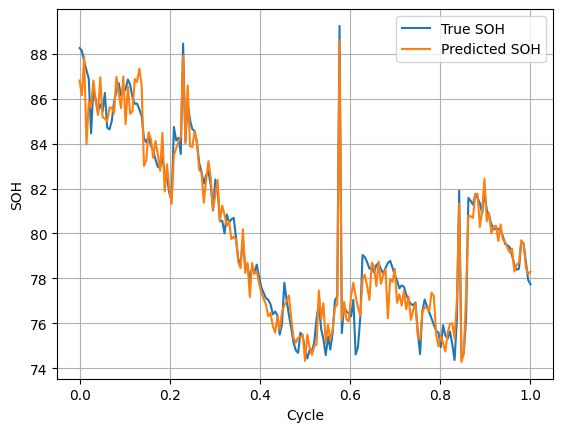

In [184]:
import matplotlib.pyplot as plt

plt.plot(cycle_number.numpy(), df["SoH"], label="True SOH")
plt.plot(cycle_number.numpy(), soh_pred.numpy(), label="Predicted SOH")
plt.legend()
plt.xlabel("Cycle")
plt.ylabel("SOH")
plt.grid()
plt.show()


In [185]:
torch.save(model.state_dict(), "model_weights.pth")


In [189]:
import torch
import torch.nn as nn

class TransformerPINN(nn.Module):
    def __init__(
        self,
        input_dim=1,        # each token is scalar
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1
    ):
        super().__init__()

        # embed scalar → d_model
        self.embedding = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # regression head
        self.regressor = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, voltage, soc, current, temp, cycles):
        # 1. Stack features as tokens
        x = torch.stack(
        [voltage, soc, current, temp, cycles],
        dim=1)  

   
        x = self.embedding(x)      # (batch, 5, d_model)

    
        x = self.transformer(x)    # (batch, 5, d_model)

    
        x = x[:, -1, :]            # (batch, d_model)

    
        soh = self.regressor(x)    # (batch, 1)
        return soh



In [202]:
model=TransformerPINN()
train_physics_informed(
    model,voltage, soc, current, temp, cycle_number,soh_norm,
)

Epoch 0/5000 | Total: 0.283504 | Data: 0.247780 | Phys: 0.035724
R2          : 0.6242
Adjusted R2 : 0.6144
MAE         : 0.1247
MSE         : 0.0254
RMSE        : 0.1594
--------------------------------------------------
Epoch 500/5000 | Total: 0.035426 | Data: 0.027803 | Phys: 0.007623
R2          : 0.3367
Adjusted R2 : 0.3194
MAE         : 0.1736
MSE         : 0.0448
RMSE        : 0.2118
--------------------------------------------------
Epoch 1000/5000 | Total: 0.021764 | Data: 0.018656 | Phys: 0.003107
R2          : 0.6863
Adjusted R2 : 0.6781
MAE         : 0.1073
MSE         : 0.0212
RMSE        : 0.1456
--------------------------------------------------
Epoch 1500/5000 | Total: 0.019208 | Data: 0.016842 | Phys: 0.002366
R2          : 0.7289
Adjusted R2 : 0.7218
MAE         : 0.0998
MSE         : 0.0183
RMSE        : 0.1354
--------------------------------------------------
Epoch 2000/5000 | Total: 0.017827 | Data: 0.015365 | Phys: 0.002461
R2          : 0.7614
Adjusted R2 : 0.755

TransformerPINN(
  (embedding): Linear(in_features=1, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [206]:
model = TransformerPINN()   # same architecture
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


TransformerPINN(
  (embedding): Linear(in_features=1, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [207]:
with torch.no_grad():
    soh_pred_norm = model(voltage, soc, current, temp, cycle_number)
    soh_pred = soh_pred_norm * (soh_max - soh_min) + soh_min


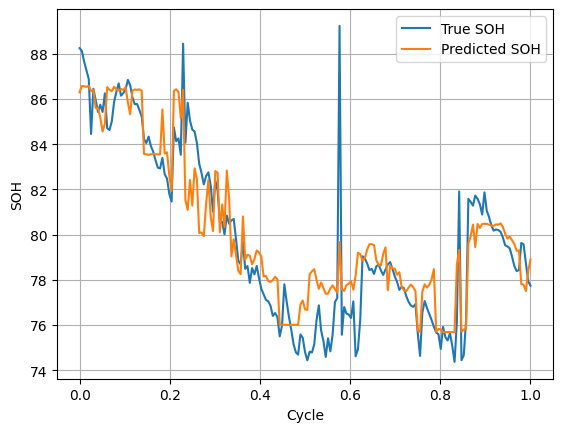

In [208]:
import matplotlib.pyplot as plt

plt.plot(cycle_number.numpy(), df["SoH"], label="True SOH")
plt.plot(cycle_number.numpy(), soh_pred.numpy(), label="Predicted SOH")
plt.legend()
plt.xlabel("Cycle")
plt.ylabel("SOH")
plt.grid()
plt.show()
